In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
# {"grid.color": ".6", "grid.linestyle": ":"}
sns.set(font_scale = 1.1)
sns.set_style(style = "white")

In [2]:
t_unet_per_vox = 28.00 # nanoseconds
nc = 32
from tomo2mesh.projects.steel_part_vis.rw_utils import time_logs as fpath

In [3]:
def get_df(vol_name):
    if vol_name == "2k":
        fname = f'subsetrec_times_n2048_ntheta1500_nc32.csv'
        ntheta = 1500; n = 2048; nz = 2048
    elif vol_name == "4k":
        fname = f'subsetrec_times_n4096_ntheta3000_nc32.csv'
        ntheta = 3000; n = 4096; nz = 4096
    else:
        raise ValuError("not found")
    
    df = pd.read_csv(os.path.join(fpath, fname))
    
    df['${1/r}$'] = 1.0/df['r_fac']
    df['t_fbp_gpu'] = df['t_filt'] + df['t_mask'] + df['t_bp']
    df['t_fbp'] = df['t_cpu2gpu'] + df['t_fbp_gpu'] + df['t_gpu2cpu']
    df['speedup-fbp-gpu'] = df['t_fbp_gpu'].iloc[-1]/df['t_fbp_gpu']
    df['speedup-bp'] = df['t_bp'].iloc[-1]/df['t_bp']
    df['speedup-fbp'] = df['t_fbp'].iloc[-1]/df['t_fbp']
    df["t_seg"] = df['r_fac']*n*n*nc*t_unet_per_vox*1.0e-6
    df["t_rec"] = df["t_seg"] + df["t_fbp"]
    df['speedup-rec'] = df['t_rec'].iloc[-1]/df['t_rec']   

    return df, ntheta, n, nz

In [4]:
def speedup_curve(df, ntheta, n, nz, ax, axis_labels = False):
    labels = ['${1/r}$', 'speedup-bp', 'speedup-fbp-gpu', 'speedup-fbp', 'speedup-rec']
    colors = ['orange', 'red', 'blue', 'green', 'black']
    markers = ['--', 'x-', 'o-', '*-', '-^']

    for iplot, label in enumerate(labels):
        ax.plot(df['${1/r}$'], df[label], markers[iplot], color = colors[iplot], label = label)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([1,100])
    ax.set_ylim([1,100])
    ax.set_title(f"ntheta = {ntheta}, n = {n}, nz = {nz}", fontweight = "bold")    
    
    if axis_labels:
        ax.legend()
        ax.set_ylabel("computational speed-up")
    ax.set_xlabel("sparsity (${1/r}$)")
    
    return

In [5]:
def time_measurements(df, ntheta, n, nz, ax, axis_labels = False):
    multiplier = nz/nc
    
    labels = ['t_fbp', 't_seg', 't_rec']
    colors = ['red', 'blue', 'green']
    markers = ['x--', 'o--', '*--']

    for iplot, label in enumerate(labels):
        ax.plot(df['${1/r}$'], multiplier*df[label]/1000.0, markers[iplot], color = colors[iplot], label = label)
            
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([1,100])
    ax.set_ylim([1,1e4])
    
    if axis_labels:
        ax.legend()
        ax.set_ylabel(f"computation time (seconds)")
    ax.set_xlabel("sparsity (${1/r}$)")
    
    return

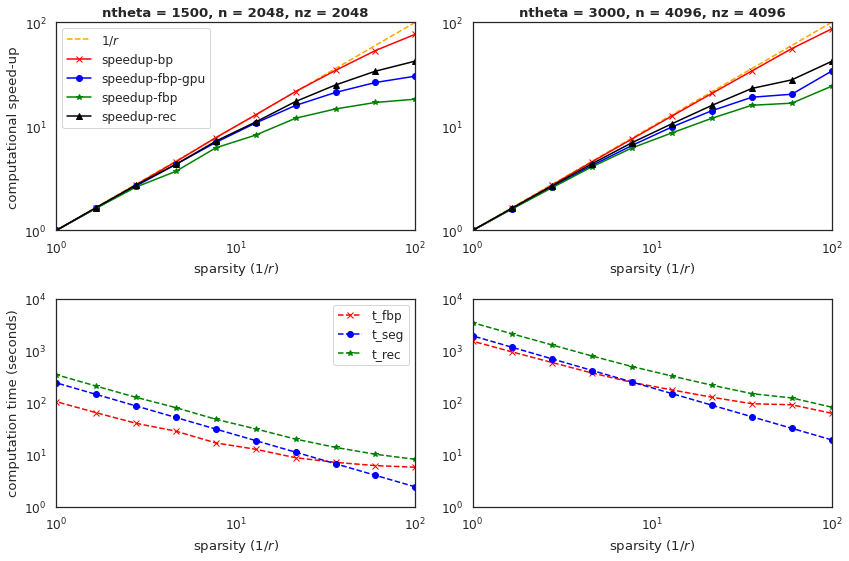

In [6]:
fig, ax = plt.subplots(2,2, figsize = (12,8))
# 2k volume
df, ntheta, n, nz = get_df("2k")
speedup_curve(df, ntheta, n, nz, ax[0,0], axis_labels = True)
time_measurements(df, ntheta, n, nz, ax[1,0], axis_labels = True)
# 4k volume
df, ntheta, n, nz = get_df("4k")
speedup_curve(df, ntheta, n, nz, ax[0,1])
time_measurements(df, ntheta, n, nz, ax[1,1])

fig.tight_layout()

In [7]:
print(get_df("2k")[0][['${1/r}$','speedup-rec']].iloc[0])
print(get_df("4k")[0][['${1/r}$','speedup-rec']].iloc[0])

${1/r}$        100.000000
speedup-rec     42.391709
Name: 0, dtype: float64
${1/r}$        100.000000
speedup-rec     42.144151
Name: 0, dtype: float64


In [8]:
print(get_df("2k")[0]['t_rec'].iloc[-1]/32*2048/1000/60)
print(get_df("4k")[0]['t_rec'].iloc[-1]/32*4096/1000/60)

5.753071604359115
57.411662678622925


In [9]:
df, ntheta, n, nz = get_df("2k")
time_labels = ["t_seg", "t_rec", "t_fbp"]
for label in time_labels:
    multiplier = nz/nc
    df[label+"-secs"] = multiplier*df[label]/1000.0   
df[['${1/r}$',"t_seg-secs", "t_rec-secs", "t_fbp-secs"]]

,${1/r}$,t_seg-secs,t_rec-secs,t_fbp-secs
0,100.000000,2.405182,8.142731,5.737550
1,59.948425,4.012085,10.177691,6.165607
2,35.938137,6.692561,13.811403,7.118842
3,21.544347,11.163864,19.904196,8.740332
4,12.915497,18.622448,31.316880,12.694432
5,7.742637,31.064116,47.884463,16.820347
6,4.641589,51.818069,80.106907,28.288839
7,2.782559,86.437748,126.558298,40.120550
8,1.668101,144.186854,208.242112,64.055258
9,1.000000,240.518169,345.184296,104.666128


In [11]:
get_df("4k")[0]

,t_cpu2gpu,t_filt,t_mask,t_bp,t_gpu2cpu,r_fac,${1/r}$,t_fbp_gpu,t_fbp,speedup-fbp-gpu,speedup-bp,speedup-fbp,t_seg,t_rec,speedup-rec
0,155.395203,96.225090,103.766464,116.030975,16.821920,0.010000,100.000000,316.022530,488.239653,33.975632,86.450077,24.330943,150.323855,638.563508,42.144151
1,155.632446,92.805122,255.029251,179.445114,28.065472,0.016681,59.948425,527.279488,710.977406,20.363139,55.899470,16.708451,250.755304,961.732709,27.982533
2,155.377533,94.767235,174.433121,294.375427,25.673729,0.027826,35.938137,563.575783,744.627045,19.051680,34.075150,15.953398,418.285057,1162.912102,23.141660
3,156.166214,94.757469,180.305786,483.422760,77.482590,0.046416,21.544347,758.486015,992.134819,14.155917,20.749720,11.973505,697.741528,1689.876347,15.925258
4,155.715332,93.875938,195.938431,796.010132,129.206650,0.077426,12.915497,1085.824501,1370.746483,9.888398,12.601456,8.666323,1163.903018,2534.649501,10.617530
5,155.949692,92.895805,219.822174,1322.507324,119.397568,0.129155,7.742637,1635.225304,1910.572563,6.566108,7.584749,6.217681,1941.507250,3852.079814,6.986282
6,154.458405,92.831871,258.764801,2190.630859,199.704834,0.215443,4.641589,2542.227531,2896.390770,4.223487,4.578995,4.101426,3238.629287,6135.020057,4.386574
7,156.143967,91.918945,326.181122,3667.564697,359.358002,0.359381,2.782559,4085.664764,4601.166733,2.627985,2.735027,2.581808,5402.359254,10003.525987,2.690223
8,155.519104,91.848640,430.644928,6109.506348,554.069702,0.599484,1.668101,6631.999916,7341.588722,1.618978,1.641849,1.618087,9011.678374,16353.267096,1.645648
9,155.629791,91.811295,614.367249,10030.886719,986.636292,1.000000,1.000000,10737.065262,11879.331345,1.000000,1.000000,1.000000,15032.385536,26911.716881,1.000000
